# Siamese Neural Network

Siamese neural network is a class of neural network architectures that contain two or more identical sub networks. identical here means they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub networks.It is used find the similarity of the inputs by comparing its feature vectors.

For more details check this blog : https://innovationincubator.com/siamese-neural-network-with-code-example/

## Steps to create classifier using Siamese Neural Network 


1.   **Data Preprocessing**
2.   **Define the Siamese Network**
3.   **Feature Vector Extraction**
4.   **Similarity Score Calculation**
5.   **Defininf Loss Function**
6.   **Optimizer**
7.   **Testing using One-Shot Learnig**
8.   **Making Predictions**



Let's  go step wise 

## Import and Install all the necessary packages

In [1]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
from sklearn.model_selection import train_test_split
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import random
plt.rcParams["figure.figsize"] = (15,15)

### Additional Utility Functions 

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### Statified Split

In [3]:
data = pd.read_csv('../Signature Matching/input/custom/data.csv').sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,[0,1]],data.iloc[:,[2]],test_size=0.1,stratify=data.iloc[:,[2]])

In [152]:
pd.concat([X_train,y_train],axis=1).to_csv('../Signature Matching/input/custom/train_data.csv',index=False)
pd.concat([X_test,y_test],axis=1).to_csv('../Signature Matching/input/custom/test_data.csv',index=False)

In [4]:
class Config():
    data_dir = "../Signature Matching/input/custom/full"
    train_batch_size = 32
    train_number_epochs = 20

## Load Dataset :

Datasets can be downloaded from this Link:  https://drive.google.com/file/d/1q03FLpaolm6Jq5vM0a_AEnjJoqjtxgP8/view?usp=sharing

**Copy the dataset directly to your drive and load it from there**

In [5]:
data_dir = "../Signature Matching/input/custom/full"
training_csv = "../Signature Matching/input/custom/train_data.csv"
testing_csv = "../Signature Matching/input/custom/test_data.csv"

### Preprocessing and Loading Dataset

We preprocessed all the images and loaded them as .npy files which is easy to transfer . You can follow your own preprocessing steps .


In [6]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        print(image1_path,image2_path)
        
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [7]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv,data_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

../Signature Matching/input/custom/full\102/102_11.png ../Signature Matching/input/custom/full\102_forg/102_forg_05.png
../Signature Matching/input/custom/full\112/112_15.png ../Signature Matching/input/custom/full\112_forg/112_forg_17.png
../Signature Matching/input/custom/full\087/087_10.png ../Signature Matching/input/custom/full\087_forg/087_forg_23.png
../Signature Matching/input/custom/full\093/093_02.png ../Signature Matching/input/custom/full\093/093_16.png
../Signature Matching/input/custom/full\060/060_07.png ../Signature Matching/input/custom/full\060/060_01.png
../Signature Matching/input/custom/full\026/026_01.png ../Signature Matching/input/custom/full\026_forg/026_forg_03.png
../Signature Matching/input/custom/full\084/084_01.png ../Signature Matching/input/custom/full\084/084_07.png
../Signature Matching/input/custom/full\086/086_08.png ../Signature Matching/input/custom/full\086_forg/086_forg_08.png


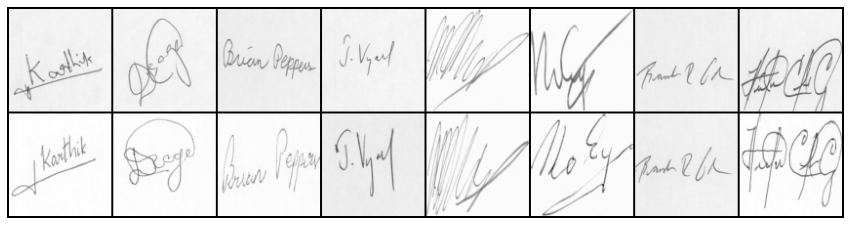

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]


In [8]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Siamese Network Definition

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

### Loss Function

In [11]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        #loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) + (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

### Train the Model

In [12]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [13]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

In [14]:
# Declare Siamese Network
net = SiameseNetwork()#.cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [15]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

In [16]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("../Signature Matching/output/model.pt",map_location=torch.device('cpu')))

FileNotFoundError: [Errno 2] No such file or directory: '../Signature Matching/output/model.pt'

In [17]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=data_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

../Signature Matching/input/custom/full\092/092_21.png ../Signature Matching/input/custom/full\092_forg/092_forg_00.png
../Signature Matching/input/custom/full\124/124_16.png ../Signature Matching/input/custom/full\124_forg/124_forg_13.png
../Signature Matching/input/custom/full\096/096_21.png ../Signature Matching/input/custom/full\096/096_03.png
../Signature Matching/input/custom/full\117/117_00.png ../Signature Matching/input/custom/full\117_forg/117_forg_03.png
../Signature Matching/input/custom/full\094/094_23.png ../Signature Matching/input/custom/full\094_forg/094_forg_16.png
../Signature Matching/input/custom/full\077/077_16.png ../Signature Matching/input/custom/full\077_forg/077_forg_07.png
../Signature Matching/input/custom/full\073/073_13.png ../Signature Matching/input/custom/full\073_forg/073_forg_05.png
../Signature Matching/input/custom/full\114/114_21.png ../Signature Matching/input/custom/full\114_forg/114_forg_12.png


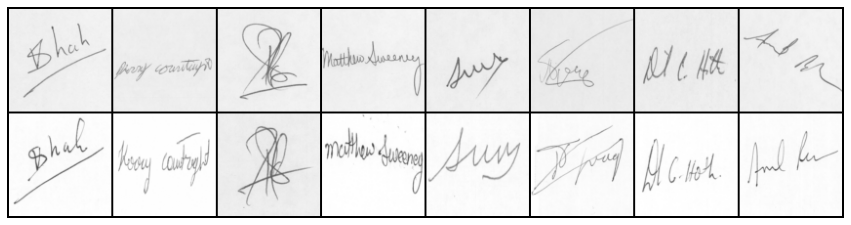

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [18]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(test_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[1]])
list_1 = torch.FloatTensor([[0]])
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    print(x0.size())
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    if label==list_0:
        label="Orginial"
    else:
        label="Forged"
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter=counter+1
    break
    if counter ==20:
        break

In [41]:
from PIL import Image

import torch,torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

def predict(sig1,sig2):
    trans = transforms.Compose([transforms.Resize((105,105)),transforms.ToTensor()])
    
    sig1 = Image.open(sig1)
    sig2 = Image.open(sig2)
    sig1 = sig1.convert("L")
    sig2 = sig2.convert("L")
    sig1 = trans(sig1)
    sig2 = trans(sig2)
    sig1 = sig1.unsqueeze(0)
    sig2 = sig2.unsqueeze(0)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SiameseNetwork().to(device)
    model.load_state_dict(torch.load("../Signature Matching/output/model v3.pt",map_location=torch.device('cpu')))
    output1,output2 = model(sig1.to(device),sig2.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
        
    concatenated = torch.cat((sig1,sig2),0)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(eucledian_distance.item()))

../Signature Matching/input/custom/full\035\035_06.png ../Signature Matching/input/custom/full\035\035_11.png


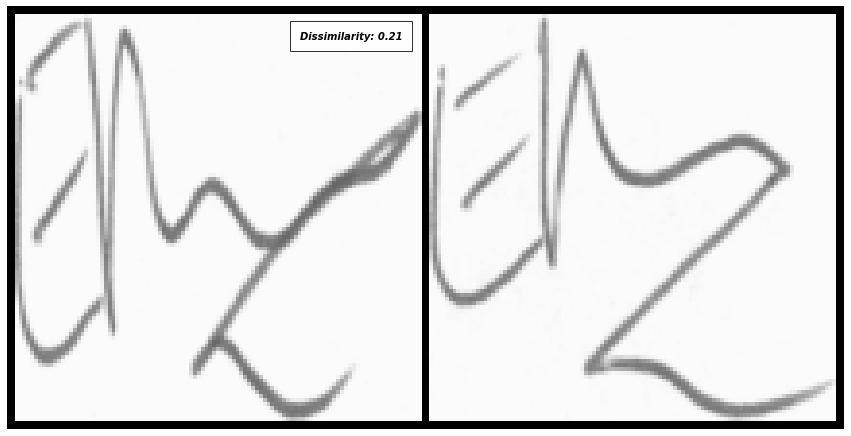

In [58]:
path = '../Signature Matching/input/custom/full'

fold = random.choice(os.listdir(path)).replace('_forg','')

org_fold = os.listdir(os.path.join(path,str(fold)))

forg_fold = os.listdir(os.path.join(path,str(fold) + '_forg'))

org1 = os.path.join(path,str(fold), random.choice(org_fold))
org2 = os.path.join(path,str(fold), random.choice(org_fold))

forg = os.path.join(path,str(fold) + '_forg', random.choice(forg_fold))
print(org1,org2)

predict(org1,org2)

## Final Touch 

Thats it guys ! I am limited by time , computational power and knowledge .to get standard accuracy . But anyway this is the working code of Siamese Neural Network and you can try it for your own applications and dataset.

Paper Reference: https://arxiv.org/pdf/1707.02131.pdf

Thanks to Gupta Blog : https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e